In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd, fiona
import folium

### Loading and Cleaning the Data


In [2]:
data = pd.read_csv("../data/city_pairs_co2_duration.csv")

In [3]:
# Drop row where "Departure City" or "Arrival City" is Tbilisi, Ibiza or Yerevan
data = data[~data["Departure City"].isin(["Tbilisi", "Ibiza", "Yerevan", "Baku"])]
data = data[~data["Arrival City"].isin(["Tbilisi", "Ibiza", "Yerevan", "Baku"])]

In [4]:
city_to_departure_country = {
    "Tirana": "Albania",
    "Vienna": "Austria",
    "Baku": "Azerbaijan",
    "Yerevan": "Armenia",
    "Sarajevo": "Bosnia and Herzegovina",
    "Torino": "Italy",
    "Minsk": "Belarus",
    "Andorra la Vella": "Andorra",
    "Copenhagen": "Denmark",
    "Zagreb": "Croatia",
    "Nicosia": "Cyprus",
    "Brno": "Czech Republic",
    "Munich": "Germany",
    "Sofia": "Bulgaria",
    "Brussels": "Belgium",
    "Toulouse": "France",
    "Prague": "Czech Republic",
    "Paris": "France",
    "Lyon": "France",
    "Tbilisi": "Georgia",
    "Budapest": "Hungary",
    "Berlin": "Germany",
    "Helsinki": "Finland",
    "Bucharest": "Romania",
    "Stockholm": "Sweden",
    "Rome": "Italy",
    "Istanbul": "Turkey",
    "Kyiv": "Ukraine",
    "Pristina": "Kosovo",
    "Hamburg": "Germany",
    "Barcelona": "Spain",
    "Reykjavik": "Iceland",
    "London": "United Kingdom",
    "Graz": "Austria",
    "Milan": "Italy",
    "Napoli": "Italy",
    "Ljubljana": "Slovenia",
    "Zurich": "Switzerland",
    "Belgrade": "Serbia",
    "Bern": "Switzerland",
    "Warszawa": "Poland",
    "Amsterdam": "Netherlands",
    "Bratislava": "Slovakia",
    "Valleta": "Malta",
    "Oslo": "Norway",
    "Chisinau": "Moldova",
    "Frankfurt": "Germany",
    "Luxembourg": "Luxembourg",
    "Geneva": "Switzerland",
    "Krakow": "Poland",
    "Nice": "France",
    "Liverpool": "United Kingdom",
    "Marseille": "France",
    "Leeds": "United Kingdom",
    "Manchester": "United Kingdom",
    "Palermo": "Italy",
    "Nottingham": "United Kingdom",
    "Sheffield": "United Kingdom",
    "Rotterdam": "Netherlands",
    "Verona": "Italy",
    "Wrocław": "Poland",
    "Venice": "Italy",
    "Gothenburg": "Sweden",
    "Antwerp": "Belgium",
    "Bordeaux": "France",
    "Bologna": "Italy",
    "Cardiff": "United Kingdom",
    "Bristol": "United Kingdom",
    "Dortmund": "Germany",
    "Duesseldorf": "Germany",
    "Cologne": "Germany",
    "Basel": "Switzerland",
    "Lausanne": "Switzerland",
    "Maribor": "Slovenia",
    "Pisa": "Italy",
    "Edinburgh": "United Kingdom",
    "Cluj-Napoca": "Romania",
    "Porto": "Portugal",
    "Madrid": "Spain",
    "Split": "Croatia",
    "Riga": "Latvia",
    "Eindhoven": "Netherlands",
    "Ibiza": "Spain",
}

city_to_arrival_country = {
    **city_to_departure_country,  # Existing mappings
    "Ibiza": "Spain",
    "Zaragoza": "Spain",
    "Moscow": "Russia",
    "Lisbon": "Portugal",
    "Valencia": "Spain",
    "Bilbao": "Spain",
    "Ankara": "Turkey",
    "Vilnius": "Lithuania",
}

# Create new column Country
data["Departure Country"] = data["Departure City"].map(city_to_departure_country)
data["Arrival Country"] = data["Arrival City"].map(city_to_arrival_country)

In [5]:
country_to_region = {
    "United Kingdom": "Western Europe",
    "Italy": "Southern Europe",
    "Germany": "Western Europe",
    "Switzerland": "Western Europe",
    "France": "Western Europe",
    "Netherlands": "Western Europe",
    "Poland": "Eastern Europe",
    "Spain": "Southern Europe",
    "Slovenia": "Southern Europe",
    "Romania": "Eastern Europe",
    "Croatia": "Southern Europe",
    "Sweden": "Northern Europe",
    "Belgium": "Western Europe",
    "Lithuania": "Eastern Europe",
    "Moldova": "Eastern Europe",
    "Luxembourg": "Western Europe",
    "Malta": "Southern Europe",
    "Norway": "Northern Europe",
    "Slovakia": "Eastern Europe",
    "Latvia": "Northern Europe",
    "Serbia": "Southern Europe",
    "Austria": "Western Europe",
    "Ukraine": "Eastern Europe",
    "Turkey": "Southern Europe",
    "Hungary": "Eastern Europe",
    "Iceland": "Northern Europe",
    "Czech Republic": "Eastern Europe",
    "Georgia": "Eastern Europe",
    "Finland": "Northern Europe",
    "Kosovo": "Southern Europe",
    "Denmark": "Northern Europe",
    "Cyprus": "Southern Europe",
    "Bulgaria": "Eastern Europe",
    "Bosnia and Herzegovina": "Southern Europe",
    "Belarus": "Eastern Europe",
    "Azerbaijan": "Eastern Europe",
    "Armenia": "Eastern Europe",
    "Andorra": "Southern Europe",
    "Russia": "Eastern Europe",
    "Portugal": "Southern Europe",
    "Albania": "Southern Europe",
}

# Create new column Region, it can be "Western Europe", "Southern Europe", "Eastern Europe", "Northern Europe"
data["Departure Region"] = data["Departure Country"].map(country_to_region)
data["Arrival Region"] = data["Arrival Country"].map(country_to_region)

In [6]:
def convert_duration_to_minutes(duration_str):
    hours, minutes = map(int, duration_str.split(":"))
    return hours * 60 + minutes


# Convert duration to minutes
data["Flight Duration"] = data["Flight Duration"].apply(convert_duration_to_minutes)
data["Train Duration"] = data["Train Duration"].apply(convert_duration_to_minutes)
data["Car Duration"] = data["Car Duration"].apply(convert_duration_to_minutes)

In [7]:
# Create a column avg_co2 that is the average of the three CO2 columns
data["avg_co2"] = data[["Train CO2", "Car CO2", "Flight CO2"]].mean(axis=1)
# Create a column avg_erc that is the average of the three Energy Resource Consumption columns
data["avg_erc"] = data[
    [
        "Train Energy Resource Consumption",
        "Car Energy Resource Consumption",
        "Flight Energy Resource Consumption",
    ]
].mean(axis=1)

In [8]:
data.head(5)

,ID,Departure City,Arrival City,Departure Coordinates,Arrival Coordinates,Train CO2,Train Energy Resource Consumption,Train Products,Train Duration,Car CO2,...,Flight CO2,Flight Energy Resource Consumption,Flight Products,Flight Duration,Departure Country,Arrival Country,Departure Region,Arrival Region,avg_co2,avg_erc
0,Tirana to Andorra la Vella,Tirana,Andorra la Vella,"{10.166386, 46.215}","{46.255559, 7.307223}",14.3,9.8,"['RE 2843', 'EC 50', '1814', 'Walk', 'Bus7...",868,30.9,...,138.0,58.6,"['Car', 'Aircraft', 'Car']",371,Albania,Andorra,Southern Europe,Southern Europe,61.066667,27.366667
2,Tirana to Vienna,Tirana,Vienna,"{10.166386, 46.215}","{16.34167, 48.206947}",10.8,13.7,"['RE 1636', 'RE 1936', '1136', '3272', 'RJX ...",685,67.4,...,120.7,51.2,"['Car', 'Aircraft', 'Car']",291,Albania,Austria,Southern Europe,Western Europe,66.300000,31.600000
4,Tirana to Torino,Tirana,Torino,"{10.166386, 46.215}","{45.060282, 7.677498}",13.4,8.0,"['RE 2817', 'Walk', 'FR 9712']",228,32.6,...,121.5,52.8,"['Train', 'Aircraft', 'Train']",262,Albania,Italy,Southern Europe,Southern Europe,55.833333,25.100000
5,Tirana to Minsk,Tirana,Minsk,"{10.166386, 46.215}","{52.175837, 21.551665}",70.8,36.8,"['RE 1644', 'RE 1944', '1144', '3276', 'RJX ...",1410,132.3,...,239.9,101.4,"['Car', 'Aircraft', 'Car']",522,Albania,Belarus,Southern Europe,Eastern Europe,147.666667,65.666667
6,Tirana to Brussels,Tirana,Brussels,"{10.166386, 46.215}","{50.896393, 4.481941}",21.6,20.2,"['RE 4632', 'RE 1334', 'ICE 70', 'ICE 10...",846,87.3,...,214.9,90.6,"['Car', 'Aircraft']",446,Albania,Belgium,Southern Europe,Western Europe,107.933333,49.866667


In [9]:
data.describe()

,Train CO2,Train Energy Resource Consumption,Train Duration,Car CO2,Car Energy Resource Consumption,Car Duration,Flight CO2,Flight Energy Resource Consumption,Flight Duration,avg_co2,avg_erc
count,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000,2811.000000
mean,55.834312,38.364034,1218.514052,128.068872,56.906688,636.795802,180.093678,76.066407,328.779082,121.332287,57.112376
std,47.295882,26.251185,809.998693,59.859951,26.603340,263.329167,59.777632,25.171085,113.491850,46.099240,22.201990
min,0.080000,1.300000,56.000000,4.200000,1.900000,95.000000,84.000000,35.300000,130.000000,31.926667,13.966667
25%,24.900000,19.800000,635.000000,82.650000,36.700000,435.000000,129.050000,54.700000,233.000000,85.950000,40.583333
50%,43.300000,33.200000,952.000000,122.200000,54.300000,618.000000,157.700000,66.600000,307.000000,114.000000,53.800000
75%,72.650000,49.300000,1620.500000,166.500000,74.000000,788.500000,236.400000,99.770000,415.000000,150.823333,70.643333
max,326.000000,188.100000,5203.000000,356.700000,158.500000,1687.000000,350.300000,147.800000,1041.000000,295.200000,145.426667


### Average CO2 and Energy Resource Consumption(ERC) by Transport Type

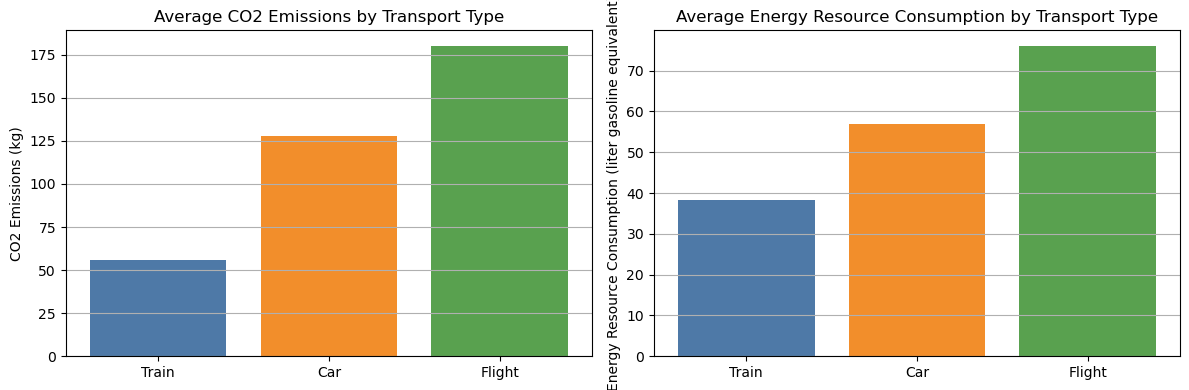

In [10]:
average_co2 = data[["Train CO2", "Car CO2", "Flight CO2"]].mean()
colors = ["#4E79A7", "#F28E2B", "#59A14F"]  # Soft Blue, Soft Orange, Soft Green

average_erc = data[
    [
        "Train Energy Resource Consumption",
        "Car Energy Resource Consumption",
        "Flight Energy Resource Consumption",
    ]
].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for CO2 emissions
ax1.bar(average_co2.index, average_co2, color=colors)
ax1.set_title("Average CO2 Emissions by Transport Type")
ax1.set_ylabel("CO2 Emissions (kg)")
ax1.set_xticks(range(len(average_co2)))
ax1.set_xticklabels(["Train", "Car", "Flight"])
ax1.grid(axis="y")

# Plot for Energy Resource Consumption
ax2.bar(
    average_erc.index,
    average_erc,
    color=colors,
)
ax2.set_title("Average Energy Resource Consumption by Transport Type")
ax2.set_ylabel("Energy Resource Consumption (liter gasoline equivalent)")
ax2.set_xticks(range(len(average_erc)))
ax2.set_xticklabels(["Train", "Car", "Flight"])
ax2.grid(axis="y")

plt.tight_layout()
plt.show()

### 10 Worst Routes According to Average CO2 Emission and ERC

In [11]:
# Define palletes
custom_palette1 = sns.color_palette("mako")
custom_palette2 = sns.color_palette("rocket")

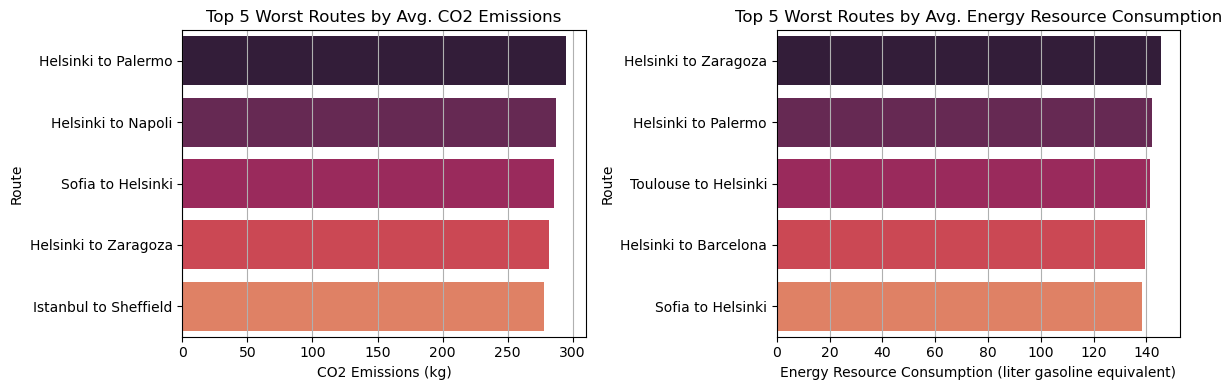

In [12]:
# Plot top 10 worst routes by CO2 emissions and erc
top_10_co2 = data.sort_values("avg_co2", ascending=False).head(5)
top_10_erc = data.sort_values("avg_erc", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# # Plot for CO2 emissions
sns.barplot(data=top_10_co2, x="avg_co2", y="ID", ax=ax1, palette=custom_palette2)
ax1.set_title("Top 5 Worst Routes by Avg. CO2 Emissions")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

# Plot for Energy Resource Consumption
sns.barplot(data=top_10_erc, x="avg_erc", y="ID", ax=ax2, palette=custom_palette2)
ax2.set_title("Top 5 Worst Routes by Avg. Energy Resource Consumption")
ax2.set_xlabel("Energy Resource Consumption (liter gasoline equivalent)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

### 10 Best Routes According to Average CO2 Emission and ERC

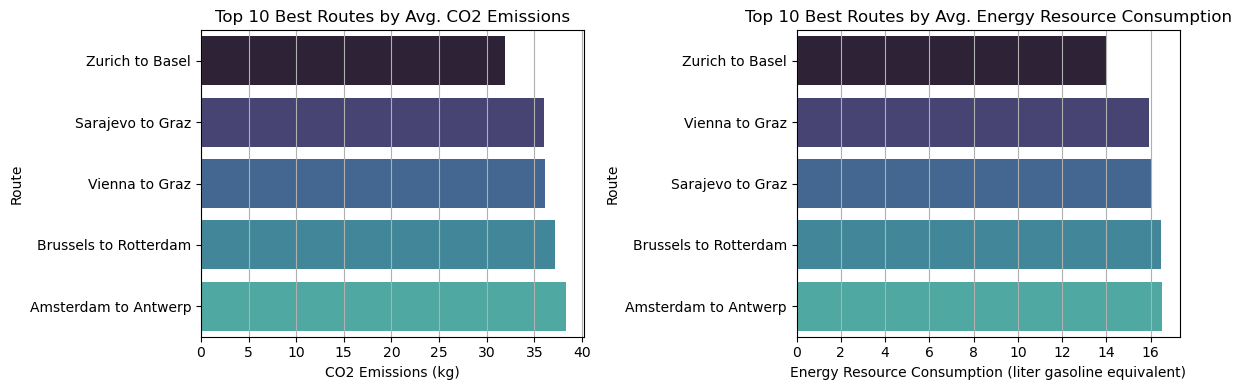

In [13]:
# Plot top 10 best routes by co2 emissions and erc

top_10_co2 = data.sort_values("avg_co2", ascending=True).head(5)
top_10_erc = data.sort_values("avg_erc", ascending=True).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for CO2 emissions
sns.barplot(data=top_10_co2, x="avg_co2", y="ID", ax=ax1, palette=custom_palette1)
ax1.set_title("Top 10 Best Routes by Avg. CO2 Emissions")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")


# Plot for Energy Resource Consumption
sns.barplot(data=top_10_erc, x="avg_erc", y="ID", ax=ax2, palette=custom_palette1)
ax2.set_title("Top 10 Best Routes by Avg. Energy Resource Consumption")
ax2.set_xlabel("Energy Resource Consumption (liter gasoline equivalent)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

**Lets do a more fine-grained analysis and see the comparison best vs worst CO2 routes by transport**

### Best vs Worst Routes (CO2) by types, Flight, Train, Car

#### Flight CO2 Comparison

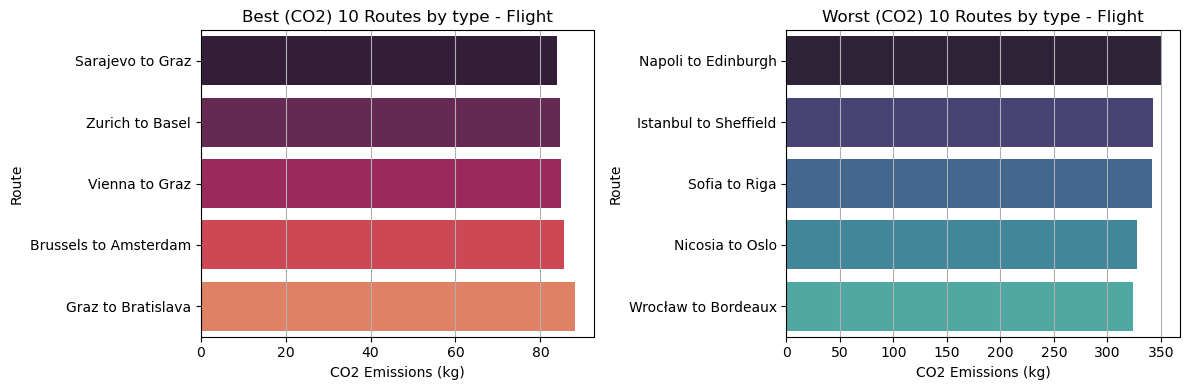

In [14]:
top_10_flight_co2 = data.sort_values("Flight CO2", ascending=True).head(5)
worst_10_flight_co2 = data.sort_values("Flight CO2", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=top_10_flight_co2, x="Flight CO2", y="ID", ax=ax1, palette=custom_palette2
)
ax1.set_title("Best (CO2) 10 Routes by type - Flight")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(
    data=worst_10_flight_co2, x="Flight CO2", y="ID", ax=ax2, palette=custom_palette1
)
ax2.set_title("Worst (CO2) 10 Routes by type - Flight")
ax2.set_xlabel("CO2 Emissions (kg)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

#### Train CO2 Comparison

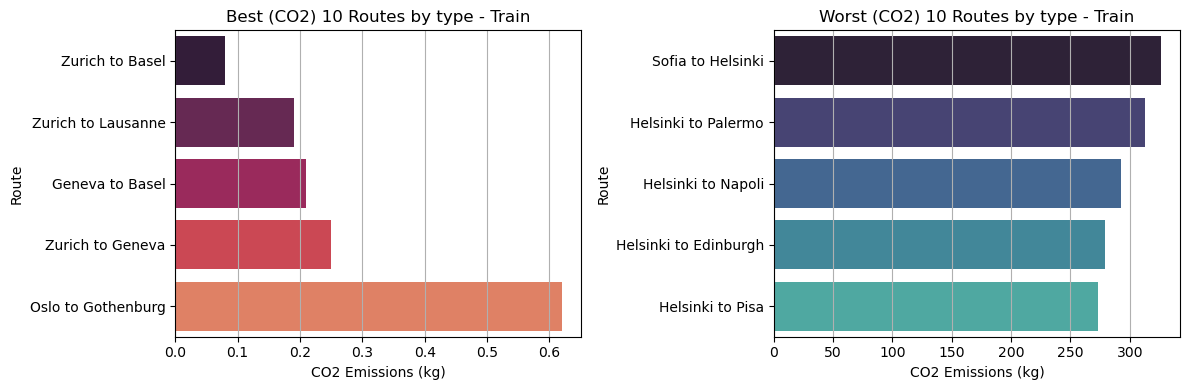

In [15]:
top_10_train_co2 = data.sort_values("Train CO2", ascending=True).head(5)
worst_10_train_co2 = data.sort_values("Train CO2", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=top_10_train_co2, x="Train CO2", y="ID", ax=ax1, palette=custom_palette2
)
ax1.set_title("Best (CO2) 10 Routes by type - Train")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(
    data=worst_10_train_co2, x="Train CO2", y="ID", ax=ax2, palette=custom_palette1
)
ax2.set_title("Worst (CO2) 10 Routes by type - Train")
ax2.set_xlabel("CO2 Emissions (kg)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

#### Car CO2 Comparison

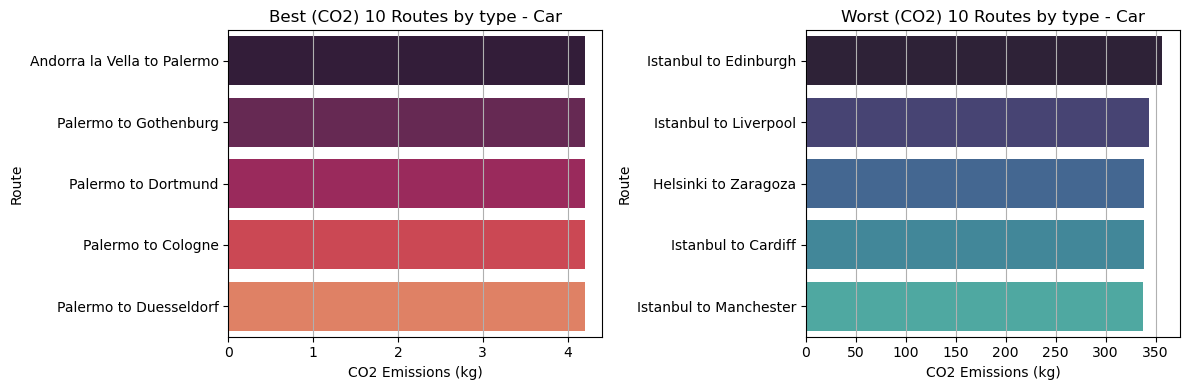

In [16]:
top_10_car_co2 = data.sort_values("Car CO2", ascending=True).head(5)
worst_10_car_co2 = data.sort_values("Car CO2", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=top_10_car_co2, x="Car CO2", y="ID", ax=ax1, palette=custom_palette2)
ax1.set_title("Best (CO2) 10 Routes by type - Car")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(data=worst_10_car_co2, x="Car CO2", y="ID", ax=ax2, palette=custom_palette1)
ax2.set_title("Worst (CO2) 10 Routes by type - Car")
ax2.set_xlabel("CO2 Emissions (kg)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

### Shortest vs Longest Routes by types, Flight, Train, Car

**Lets see the shortest vs longest route, and try to find a correlation between duration and CO2**

#### Flight Duration Comparison

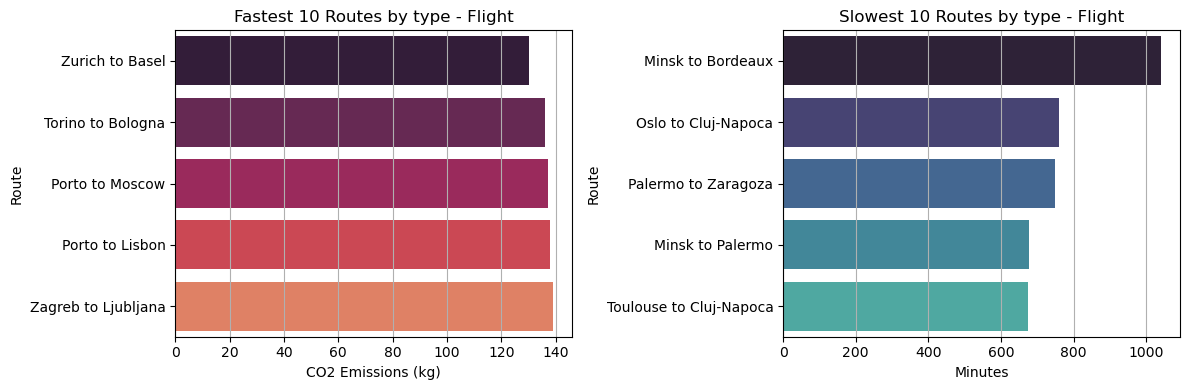

In [17]:
top_10_duration = data.sort_values("Flight Duration", ascending=True).head(5)
worst_10_duration = data.sort_values("Flight Duration", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=top_10_duration, x="Flight Duration", y="ID", ax=ax1, palette=custom_palette2
)
ax1.set_title("Fastest 10 Routes by type - Flight")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(
    data=worst_10_duration, x="Flight Duration", y="ID", ax=ax2, palette=custom_palette1
)
ax2.set_title("Slowest 10 Routes by type - Flight")
ax2.set_xlabel("Minutes")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

#### Train Duration Comparison

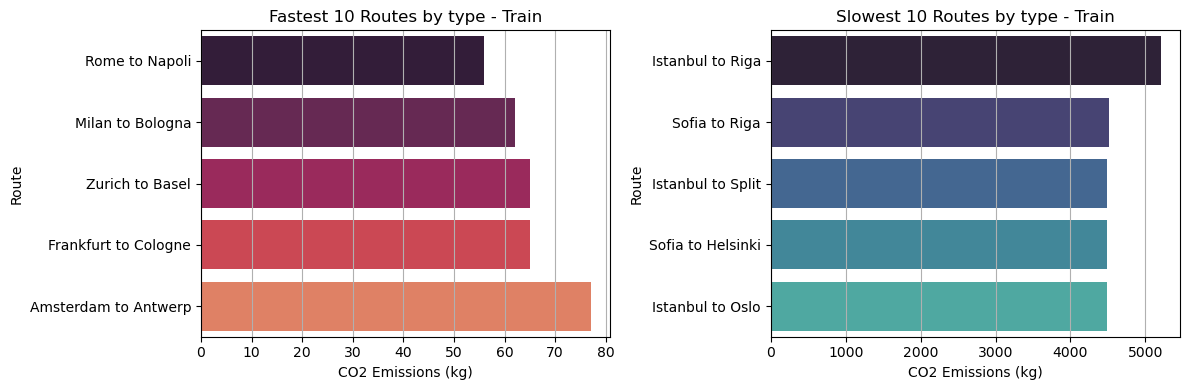

In [18]:
top_10_duration = data.sort_values("Train Duration", ascending=True).head(5)
worst_10_duration = data.sort_values("Train Duration", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=top_10_duration, x="Train Duration", y="ID", ax=ax1, palette=custom_palette2
)
ax1.set_title("Fastest 10 Routes by type - Train")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(
    data=worst_10_duration, x="Train Duration", y="ID", ax=ax2, palette=custom_palette1
)
ax2.set_title("Slowest 10 Routes by type - Train")
ax2.set_xlabel("CO2 Emissions (kg)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

#### Car Duration Comparison

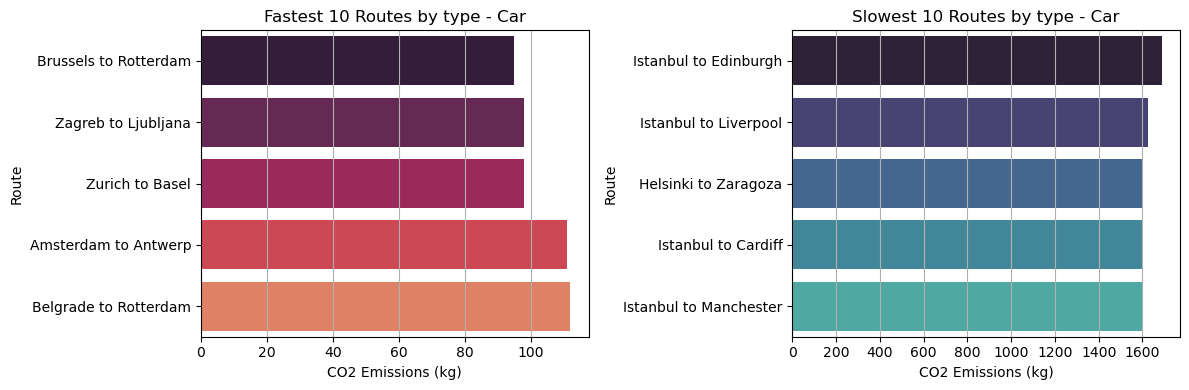

In [19]:
top_10_duration = data.sort_values("Car Duration", ascending=True).head(5)
worst_10_duration = data.sort_values("Car Duration", ascending=False).head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=top_10_duration, x="Car Duration", y="ID", ax=ax1, palette=custom_palette2
)
ax1.set_title("Fastest 10 Routes by type - Car")
ax1.set_xlabel("CO2 Emissions (kg)")
ax1.set_ylabel("Route")
ax1.grid(axis="x")

sns.barplot(
    data=worst_10_duration, x="Car Duration", y="ID", ax=ax2, palette=custom_palette1
)
ax2.set_title("Slowest 10 Routes by type - Car")
ax2.set_xlabel("CO2 Emissions (kg)")
ax2.set_ylabel("Route")
ax2.grid(axis="x")

plt.tight_layout()
plt.show()

### CO2 Emission by Duration

**Here we want to check the relationship between the duration and CO2 emission. We also want to visually compare the duration distribution among the three means of transport.**

/home/stef/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/stef/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/stef/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


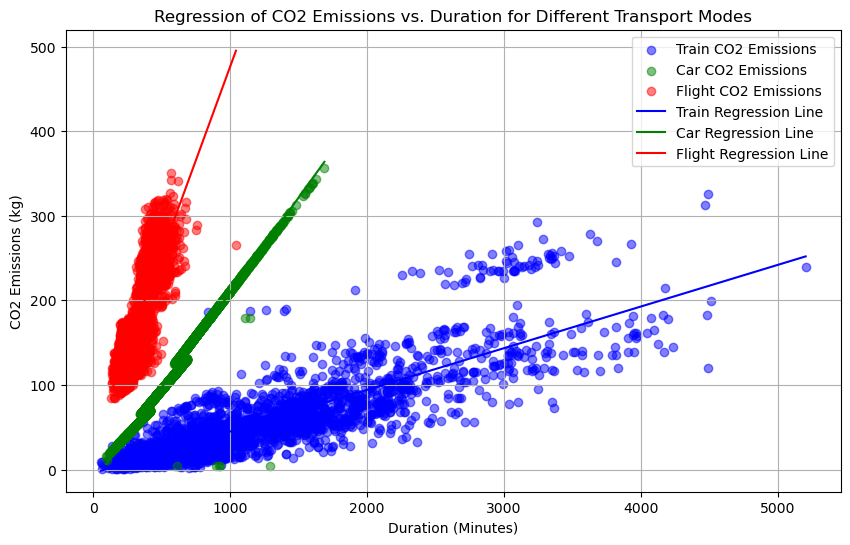

In [20]:
X_train = data[["Train Duration"]]
y_train = data["Train CO2"]

X_car = data[["Car Duration"]]
y_car = data["Car CO2"]

X_flight = data[["Flight Duration"]]
y_flight = data["Flight CO2"]

model_train = LinearRegression()
model_train.fit(X_train, y_train)

model_car = LinearRegression()
model_car.fit(X_car, y_car)

model_flight = LinearRegression()
model_flight.fit(X_flight, y_flight)

X_predict_train = np.linspace(X_train.min(), X_train.max(), 300).reshape(-1, 1)
y_predict_train = model_train.predict(X_predict_train)

X_predict_car = np.linspace(X_car.min(), X_car.max(), 300).reshape(-1, 1)
y_predict_car = model_car.predict(X_predict_car)

X_predict_flight = np.linspace(X_flight.min(), X_flight.max(), 300).reshape(-1, 1)
y_predict_flight = model_flight.predict(X_predict_flight)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color="blue", alpha=0.5, label="Train CO2 Emissions")
plt.scatter(X_car, y_car, color="green", alpha=0.5, label="Car CO2 Emissions")
plt.scatter(X_flight, y_flight, color="red", alpha=0.5, label="Flight CO2 Emissions")

plt.plot(X_predict_train, y_predict_train, color="blue", label="Train Regression Line")
plt.plot(X_predict_car, y_predict_car, color="green", label="Car Regression Line")
plt.plot(
    X_predict_flight, y_predict_flight, color="red", label="Flight Regression Line"
)

plt.title("Regression of CO2 Emissions vs. Duration for Different Transport Modes")
plt.xlabel("Duration (Minutes)")
plt.ylabel("CO2 Emissions (kg)")
plt.legend()
plt.grid(True)

plt.show()

### CO2 box-plot per Region in Europe

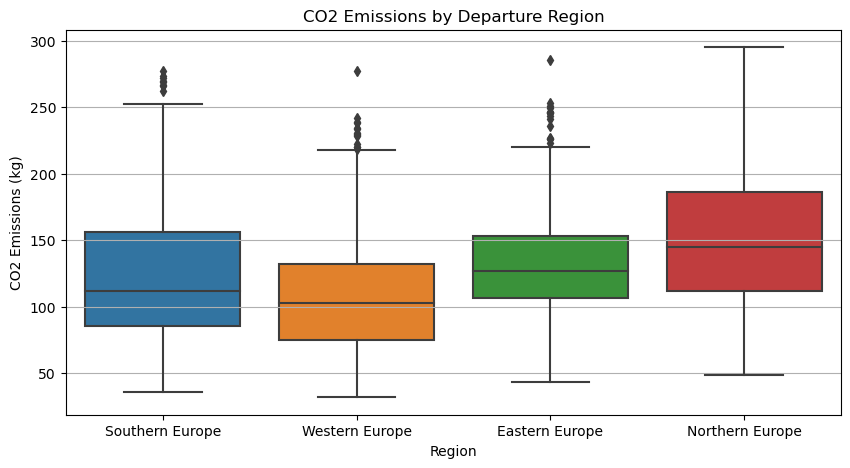

In [21]:
# CO2 box-plot by region
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x="Departure Region", y="avg_co2")
plt.title("CO2 Emissions by Departure Region")
plt.xlabel("Region")
plt.ylabel("CO2 Emissions (kg)")
plt.grid(axis="y")
plt.show()

### Visualize the KML files

#### Worst (CO2) Route by type - Train

In [22]:
fiona.drvsupport.supported_drivers["kml"] = "rw"
fiona.drvsupport.supported_drivers["KML"] = "rw"

layer_names = [
    "Intermediate Stops",
    "Intermediate Stops (#2)",
    "Intermediate Stops (#3)",
    "Intermediate Stops (#4)",
    "Intermediate Stops (#5)",
    "Intermediate Stops (#6)",
    "Intermediate Stops (#7)",
    "Intermediate Stops (#8)",
    "Route",
    "HAFAS",
]

gdfs = []

for layer_name in layer_names:
    gdf = gpd.read_file(
        "../data/kml_files/Sofia_to Helsinki.kml", driver="KML", layer=layer_name
    )
    gdfs.append(gdf)

route_coordinates = []

for _, row in gdf.iterrows():
    lon, lat, _ = row.geometry.coords[0]
    route_coordinates.append((lat, lon))

lat_mean = sum(lat for lat, lon in route_coordinates) / len(route_coordinates)
lon_mean = sum(lon for lat, lon in route_coordinates) / len(route_coordinates)

m = folium.Map(
    location=[lat_mean, lon_mean],
    zoom_start=5,
    control_scale=True,
    tiles="CartoDB Voyager",
)

for gdf in gdfs[:-2]:
    for _, row in gdf.iterrows():
        point = row.geometry
        folium.CircleMarker(
            location=[point.y, point.x],
            radius=5,
            color="#3388ff",
            popup=f"Lat: {point.y}, Lon: {point.x}",
        ).add_to(m)

for _, row in gdfs[-2].iterrows():
    segment = [(pt[1], pt[0]) for pt in row.geometry.coords]
    folium.PolyLine(
        segment,
        color="#3388ff",
        weight=3,
        opacity=0.8,
        popup="Sofia to Helsinki - Train",
    ).add_to(m)

m

![Sofia To Helsinki](../data/maps/Sofia_Helsinki.png)


#### Best (CO2) Route by type - Train

In [23]:
layer_names = [
    "Route",
    "HAFAS",
]

gdfs = []

for layer_name in layer_names:
    gdf = gpd.read_file(
        "../data/kml_files/Zurich_to Basel.kml", driver="KML", layer=layer_name
    )
    gdfs.append(gdf)

route_coordinates = []

for _, row in gdf.iterrows():
    lon, lat, _ = row.geometry.coords[0]
    route_coordinates.append((lat, lon))

lat_mean = sum(lat for lat, lon in route_coordinates) / len(route_coordinates)
lon_mean = sum(lon for lat, lon in route_coordinates) / len(route_coordinates)

m = folium.Map(
    location=[lat_mean, lon_mean],
    zoom_start=10,
    control_scale=True,
    tiles="CartoDB Voyager",
)

for gdf in gdfs[:-2]:
    for _, row in gdf.iterrows():
        point = row.geometry
        folium.CircleMarker(
            location=[point.y, point.x],
            radius=5,
            color="#3388ff",
            popup=f"Lat: {point.y}, Lon: {point.x}",
        ).add_to(m)

for _, row in gdfs[-2].iterrows():
    segment = [(pt[1], pt[0]) for pt in row.geometry.coords]
    folium.PolyLine(
        segment,
        color="#3388ff",
        weight=3,
        opacity=0.8,
        popup="Zurich to Basel - Train",
    ).add_to(m)

m

![Zurich To Basel](../data/maps/Zurich_Basel.png)